## Monte Carlo methods for errors estimation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
# it is returning P(t)
def fit_function(t,P0,n,k):
    return 2*P0 - np.power(((n-1)*k*t + (P0)**(1-n)),(1/(1-n)))

In [4]:
# generalizing y error on x error with least square method
def eff_sigma_y(t,sigma_x,sigma_y,P0,n,k):
    deriv=-(1-n)*np.power(((n-1)*k*t + (P0)**(1-n)),(1/-n))*(n-1)*k
    delta_y=deriv*sigma_x
    return np.sqrt(sigma_y*sigma_y+delta_y*delta_y)

In [5]:
def get_error_fit_popt(pcov):
    return np.sqrt(np.diag(pcov)) #estimation of uncertainity of our parameters

Load the data from `P_vs_t.txt` and fit them with the model:

In [6]:
t,P=np.loadtxt("P_vs_t.txt",unpack=True,skiprows=1)

In [7]:
#intrinsic errors
sigma_t=1 #s
sigma_P=1 #mmHg

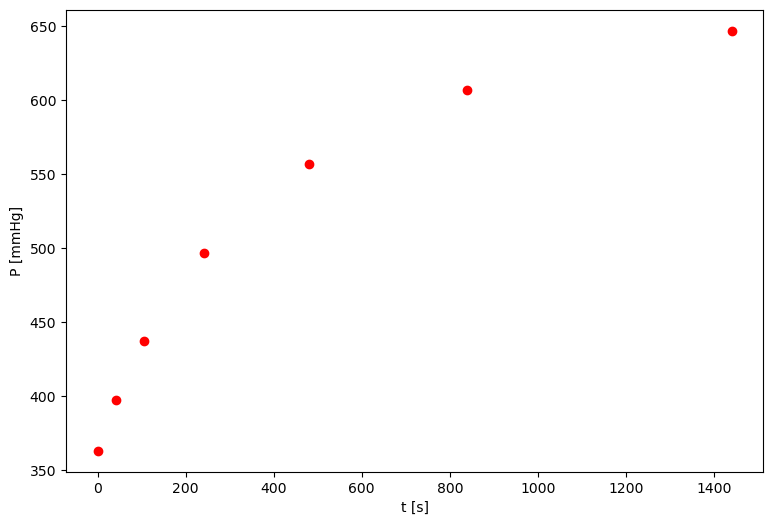

In [8]:
plt.figure(figsize=(9,6))
plt.plot(t,P,color='red',marker='o',linestyle='none',markersize=6) 
plt.xlabel("t [s]")
plt.ylabel("P [mmHg]")
plt.show()

In [9]:
popt,pcov=curve_fit(fit_function,t,P,p0=[364.08,1.983,7.153e-06]) 
#if you don't provide P0 the fit is not going to converge
perr=get_error_fit_popt(pcov)
print('P_0= {:.2f} \u00B1 {:.2f} mmHg, n= {:.3f} \u00B1 {:.1e} and k={:.2e} \u00B1 {:.2e} 1/s'
      .format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))

P_0= 363.74 ± 0.68 mmHg, n= 1.977 ± 2.0e-02 and k=7.45e-06 ± 8.34e-07 1/s


The values found in the original work are:

In [10]:
popt_orig=[364.08,1.983,7.153e-06]
perr_orig=[1,0.0259,1.065e-06]
print('P_0= {:.2f} \u00B1 {:.2f} mmHg, n= {:.3f} \u00B1 {:.1e} and k={:.2e} \u00B1 {:.2e} 1/s'
      .format(popt_orig[0],perr_orig[0],popt_orig[1],perr_orig[1],popt_orig[2],perr_orig[2]))

P_0= 364.08 ± 1.00 mmHg, n= 1.983 ± 2.6e-02 and k=7.15e-06 ± 1.06e-06 1/s


While the paper by Alper \& Gelb yields:

In [11]:
popt_paper=[363.95,1.976,7.454e-06]
perr_paper=[0.997,0.0252,1.090e-06]
print('P_0= {:.2f} \u00B1 {:.2f} mmHg, n= {:.3f} \u00B1 {:.1e} and k={:.2e} \u00B1 {:.2e} 1/s'
      .format(popt_paper[0],perr_paper[0],popt_paper[1],perr_paper[1],popt_paper[2],perr_paper[2]))

P_0= 363.95 ± 1.00 mmHg, n= 1.976 ± 2.5e-02 and k=7.45e-06 ± 1.09e-06 1/s


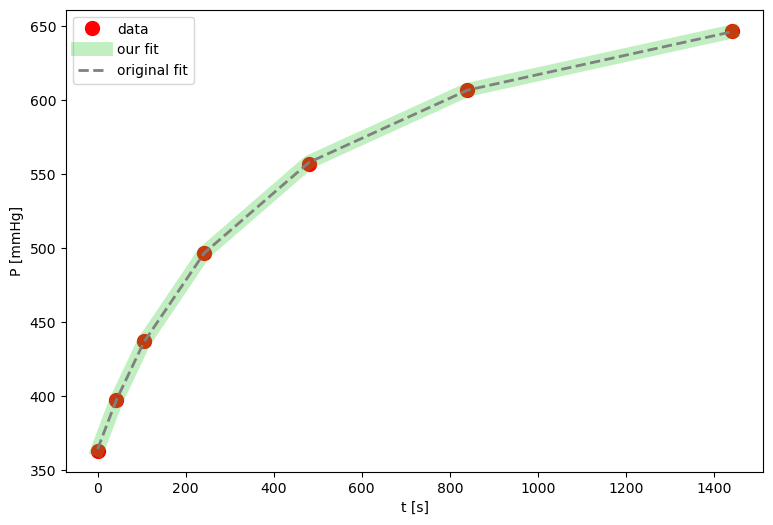

In [12]:
plt.figure(figsize=(9,6))
plt.plot(t,P,color='red',marker='o',linestyle='none',markersize=10,label="data") 
plt.plot(t,fit_function(t,*popt),color='limegreen',lw=10,alpha=0.3,label="our fit")
plt.plot(t,fit_function(t,*popt_orig),color='gray',lw=2,linestyle='dashed',label="original fit")
plt.xlabel("t [s]")
plt.ylabel("P [mmHg]")
plt.legend()
plt.show()

Use generalized least squares:

In [13]:
ndata=len(P)
eff_err=np.zeros(ndata) #create array filled of '0' saving effective errors into it
for i in range (0,ndata):
    eff_err[i]=eff_sigma_y(t[i],sigma_t,sigma_P,popt[0],popt[1],popt[2])

In [14]:
popt_w,pcov_w=curve_fit(fit_function,t,P,p0=popt,sigma=eff_err)
perr_w=get_error_fit_popt(pcov_w)
print('P_0= {:.2f} \u00B1 {:.2f} mmHg, n= {:.3f} \u00B1 {:.1e} and k={:.2e} \u00B1 {:.2e} 1/s'
      .format(popt_w[0],perr_w[0],popt_w[1],perr_w[1],popt_w[2],perr_w[2]))

P_0= 363.74 ± 0.68 mmHg, n= 1.977 ± 2.0e-02 and k=7.45e-06 ± 8.34e-07 1/s


Let us apply Monte Carlo methods:

In [18]:
# noise here is sigma associated to P(t)
def Monte_Carlo (data_init,noise_data_init): #the random data generated by monte carlo 
    return data_init+np.random.normal(0,noise_data_init,size=len(data_init)) # 0 is the mean, 

In [25]:
iterations=200
data_init=P #from file
noise_data_init=sigma_P #fixed uncertainty on y data
popt_MC=np.zeros([iterations,3]) #2D arrays for MC
perr_MC=np.zeros([iterations,3]) #iterations * 3 (because 3 parameters for each fit)

for rep in range (0,iterations):
    data=Monte_Carlo(data_init,noise_data_init) 
    
    popt_MC[int(rep)],pcov_MC=curve_fit(fit_function,t,data,p0=popt)
    
# compute C.L. #an approach to calculate confidence level intervals
# you have 200 estimation of p0, n ,k
# you will discard -after sorting-the first 0.158 percent and last 0.158 percent of the data to keep the 99.7% of 
# the middle)

discard_low_15_8=int(0.158*iterations)
discard_high_15_8=int(0.158*iterations)
discard_low_5=int(0.05*iterations)
discard_high_5=int(0.05*iterations)
#if you excuted the copy you are not changing the matrix so it is functioning properly
popt_MC=np.copy(popt_MC.T)
for i in range(0,3):
    popt_MC[i]=np.sort(popt_MC[i]) #he sorted the guesses
    if i==2: #because SD limit is 1 on each side
        popt_MC[i]=1E6*(popt_MC[i])
    #otherwise print the optimized mean - the left most survived number in monte carlo confidence level to left and to right
    # for both 68.3% and 90%
    print("{:.3f} {:.3f} {:.3f} {:.3f}".format( popt_w[i]-popt_MC[i][discard_low_15_8],-popt_w[i]+popt_MC[i][-discard_high_15_8],
          popt_w[i]-popt_MC[i][discard_low_5],-popt_w[i]+popt_MC[i][-discard_high_5]))

0.871 0.826 1.275 1.358
0.026 0.020 0.043 0.035
-6.708 8.634 -6.095 9.555


In [20]:
cl_68_3=np.zeros(3)
cl_90=np.zeros(3)
#the results are arithmetic mean for 68.3% and for 90%
print("Our 68.3% confidence interval for P_0,n and k is:")
for i in range(0,3):
    cl_68_3[i]=(popt_w[i]-popt_MC[i][discard_low_15_8]-popt_w[i]+popt_MC[i][-discard_high_15_8])/2 
    print("+/-{:.3f}".format(cl_68_3[i]))
              
print("Our 90% confidence interval for P_0,n and k is:")
for i in range(0,3):
    cl_90[i]=(popt_w[i]-popt_MC[i][discard_low_5]-popt_w[i]+popt_MC[i][-discard_high_5])/2 
    print("+/-{:.3f}".format(cl_90[i]))
    
#he had shrinker confidence levels than the paper because now instruments are much developed

Our 68.3% confidence interval for P_0,n and k is:
+/-0.731
+/-0.024
+/-1.022
Our 90% confidence interval for P_0,n and k is:
+/-1.199
+/-0.041
+/-1.651


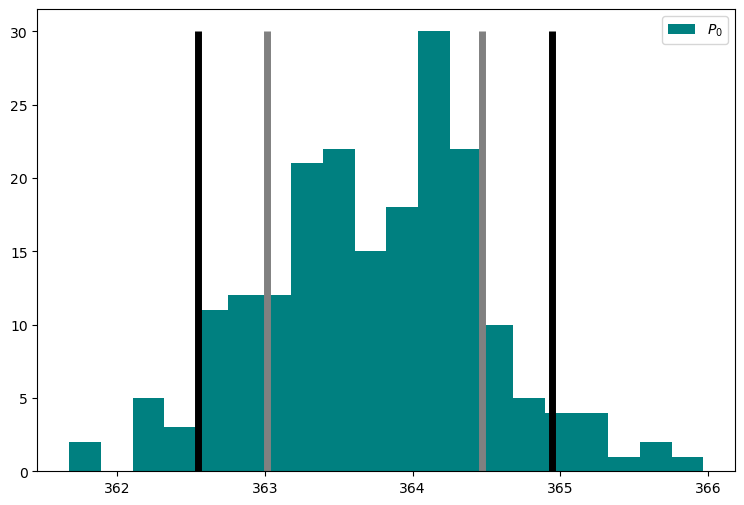

In [21]:
#P0 distribution
plt.figure(figsize=(9,6))
plt.hist(popt_MC[0],color='teal',bins=20,label='$P_0$') 
plt.vlines(popt_w[0]+cl_68_3[0],0,30,lw=5,color='gray')
plt.vlines(popt_w[0]-cl_68_3[0],0,30,lw=5,color='gray')
plt.vlines(popt_w[0]+cl_90[0],0,30,lw=5,color='black')
plt.vlines(popt_w[0]-cl_90[0],0,30,lw=5,color='black')
plt.legend()
plt.show()

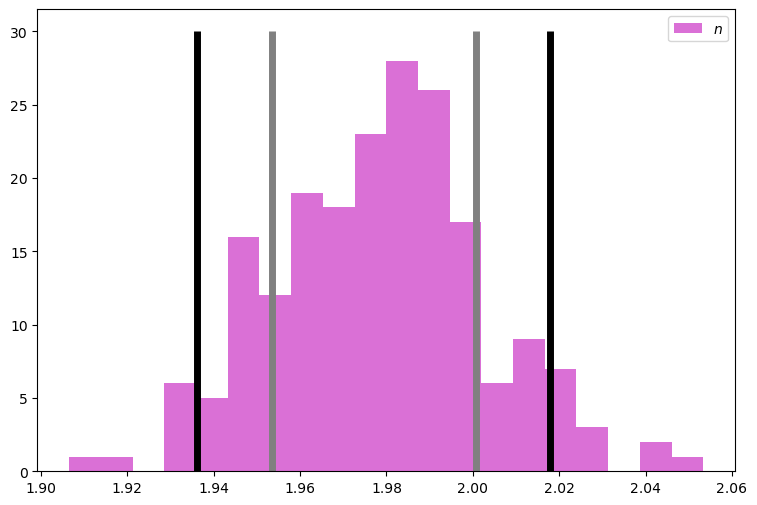

In [22]:
plt.figure(figsize=(9,6))
plt.hist(popt_MC[1],color='orchid',bins=20,label='$n$') 
plt.vlines(popt_w[1]+cl_68_3[1],0,30,lw=5,color='gray')
plt.vlines(popt_w[1]-cl_68_3[1],0,30,lw=5,color='gray')
plt.vlines(popt_w[1]+cl_90[1],0,30,lw=5,color='black')
plt.vlines(popt_w[1]-cl_90[1],0,30,lw=5,color='black')
plt.legend()
plt.show()

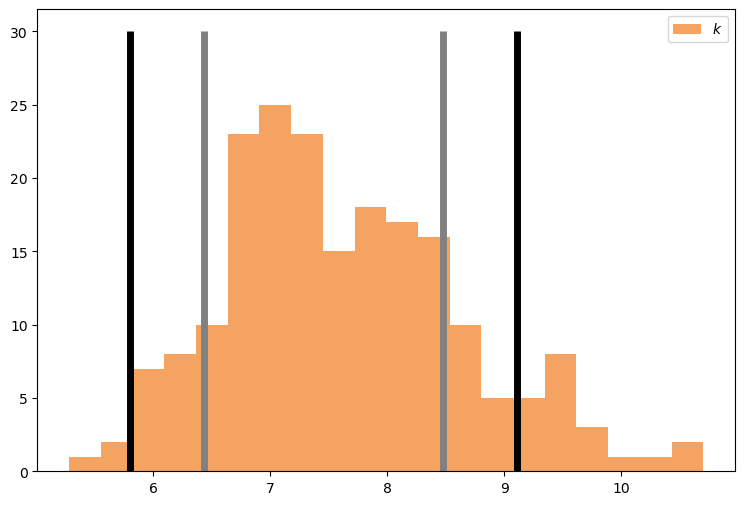

In [28]:
plt.figure(figsize=(9,6))
plt.hist(popt_MC[2],color='sandybrown',bins=20,label='$k$') 
plt.vlines(1E6*popt_w[2]+cl_68_3[2],0,30,lw=5,color='gray')
plt.vlines(1E6*popt_w[2]-cl_68_3[2],0,30,lw=5,color='gray')
plt.vlines(1E6*popt_w[2]+cl_90[2],0,30,lw=5,color='black')
plt.vlines(1E6*popt_w[2]-cl_90[2],0,30,lw=5,color='black')
plt.legend()
plt.show()
#if repeating mc is givin this, that the differences between my results and MC needs to be taking into account
#you should do another fit to know if this is a normal distribution or not

## Welch's _t-test_

In [114]:
#import ttest_ind() function
from scipy import stats
#he just generated 2 set of numbers
#define two arrays of data
first_set = [90, 85, 88, 89, 94, 91, 79, 83, 87, 88, 91, 90]
second_set = [67, 90, 71, 95, 88, 83, 72, 66, 75, 86, 93, 84]

#perform Welch's t-test 
stats.ttest_ind(first_set, second_set, equal_var = False)

Ttest_indResult(statistic=2.236067977499793, pvalue=0.041709795032077744)

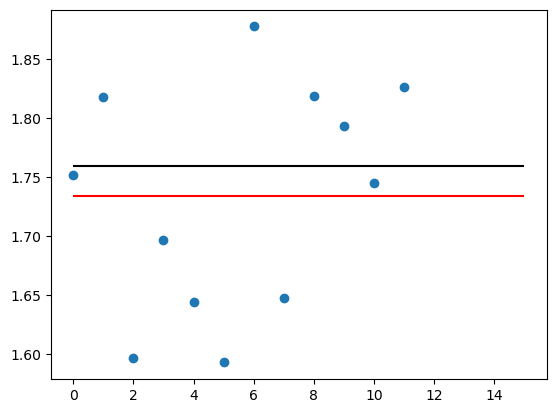

In [117]:
samples=np.array([1.752,1.818,1.597,1.697,1.644,1.593,
		   1.878,1.648,1.819,1.794,1.745,1.827])
TrueMean=1.76
# we should find statistical difference between our data
stats.ttest_1samp(samples, TrueMean)
plt.plot(samples,marker='o',linestyle='none')
plt.hlines(TrueMean,0,15,color="black")
plt.hlines(np.mean(samples),0,15,color="red")
plt.show()

In [116]:
TrueMean=1.76

#define a single data array
samples=np.array([1.752,1.818,1.597,1.697,1.644,1.593,
		   1.878,1.648,1.819,1.794,1.745,1.827])

#perform t-test 
stats.ttest_1samp(samples, TrueMean)


Ttest_1sampResult(statistic=-0.9178351622537867, pvalue=0.37839036583764296)

In [ ]:
#numpy savetxt saves your data, you have to use it
#pymc is hamiltonian Monte Carlo